# Quantum Encoder/Decoder of $BeH_2$

Plan:
1) Find the ground-state vector of $BeH_2$ at various $r$ and $\theta$ using JW Transform. Save these vectors in a JSON.
2) Choose 10% of the initial confirgurations to train autoencoder for a set number of reference states (k).
3) Test fidelity with the rest of the 90% of the configurations
4) Test how expectation values of measurment change (spin measure, energy etc.)
4) Plot the above changes against k

Theory:
* Best achievable operator error bound from fidelity (operator norm bound)
* Baseline Linear Compression (PCA) and the Eckart–Young Lower Bound
* Effective Dimensionality from the Molecular Manifold Structure

Sources:
* https://iopscience.iop.org/article/10.1088/2058-9565/aa8072/pdf
* https://qiskit-community.github.io/qiskit-machine-learning/tutorials/12_quantum_autoencoder.html
* https://arxiv.org/pdf/2012.08331

# Preparing system

In [63]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_algorithms import NumPyEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

# initialise driver
driver = PySCFDriver(
    atom="Be 0 0 0; H 0 0 1.3264073; H 0 -1.3264073 0",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

# Generate Hamiltonian
problem = driver.run()
fermionic_op = problem.hamiltonian.second_q_op() # Fermionic Hamiltonian operator
total_energy = problem.reference_energy # Energy of the system

# Convert to Pauli Strings
mapper = JordanWignerMapper()
qubit_jw_op = mapper.map(fermionic_op)
print(f'First Pauli String: {qubit_jw_op[0]}')

# Solve for ground state
solver = NumPyEigensolver(k=1)
result = solver.compute_eigenvalues(qubit_jw_op)
ground_state_vector = result.eigenstates[0].data

# Remove near-zero amplitudes
zero_ground_state = [0 if abs(ampl) < 1e-12 else ampl for ampl in ground_state_vector]
print(f'Unique coeffs: {len(set(zero_ground_state))}')

First Pauli String: SparsePauliOp(['IIIIIIIIIIIIII'],
              coeffs=[-12.20414243+0.j])
Unique coeffs: 322


# Setting up circuit

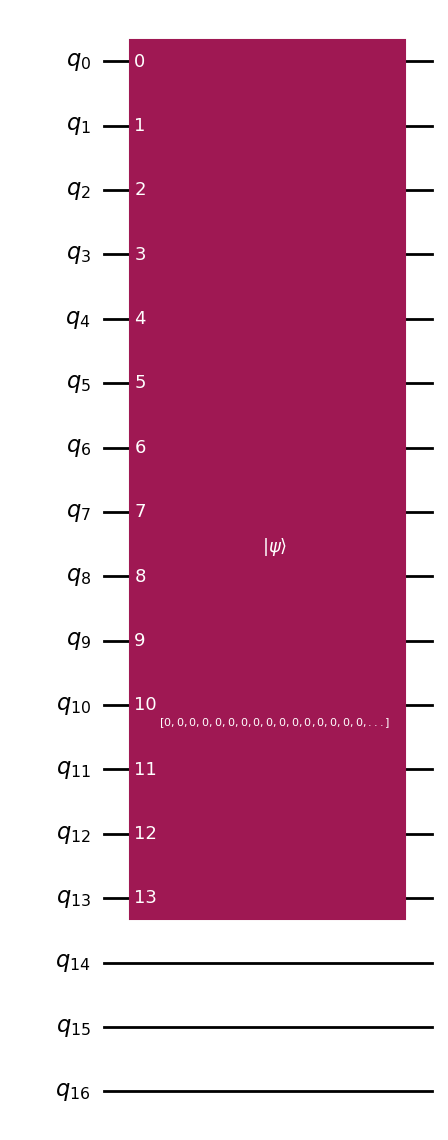

In [64]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Initialise circuit with 14 qubits
k=3
qc = QuantumCircuit(qubit_jw_op.num_qubits + k)
state = Statevector(zero_ground_state)
qc.initialize(state.data, qc.qubits[0:14])

qc.draw('mpl')